In [2]:
import datetime
import gc
import math
import os

import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tqdm.notebook import tqdm

sns.set(style='darkgrid')
train_path = '../../input/hy_round1_train_20200102'
test_path = '../../input/hy_round1_testA_20200102'

In [3]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 20)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [4]:
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

print(f"训练样本：{len(train_files)}")
print(f"测试样本：{len(test_files)}")

训练样本：7000
测试样本：2000


### 4924号

In [5]:
df_4924 = pd.read_csv(f'{train_path}/4924.csv')
print(f"作业类型：{df_4924['type'].unique()}")
print(f"数据维度：{df_4924.shape}")

作业类型：['围网']
数据维度：(3969, 7)


In [6]:
df_4924.head()

,渔船ID,x,y,速度,方向,time,type
0,4924,6.328956e+06,5.291393e+06,0.38,103,1113 23:59:30,围网
1,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:58:27,围网
2,4924,6.328956e+06,5.291393e+06,0.00,0,1113 23:57:24,围网
3,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:56:20,围网
4,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:55:17,围网


In [7]:
def df_angle_handle(dataframe):
    """方向编码"""
    if '方向' in dataframe.columns:
        sin_list = []
        cos_list = []
        for angle in dataframe['方向'].values:
            sin_list.append(math.sin(math.radians(angle)))
            cos_list.append(math.cos(math.radians(angle)))
        dataframe['sin_angle'] = sin_list
        dataframe['cos_angle'] = cos_list
        # dataframe = dataframe.drop('方向', axis=1)
    else:
        print("没有方向列或已经处理完毕")
    return dataframe

In [8]:
df_4924 = df_angle_handle(df_4924)

In [9]:
df_4924

,渔船ID,x,y,速度,方向,time,type,sin_angle,cos_angle
0,4924,6.328956e+06,5.291393e+06,0.38,103,1113 23:59:30,围网,0.974370,-0.224951
1,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:58:27,围网,0.000000,1.000000
2,4924,6.328956e+06,5.291393e+06,0.00,0,1113 23:57:24,围网,0.000000,1.000000
3,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:56:20,围网,0.000000,1.000000
4,4924,6.328956e+06,5.291393e+06,0.05,0,1113 23:55:17,围网,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
3964,4924,6.342718e+06,5.283126e+06,9.17,132,1111 00:04:36,围网,0.743145,-0.669131
3965,4924,6.342517e+06,5.283346e+06,8.96,149,1111 00:03:33,围网,0.515038,-0.857167
3966,4924,6.342316e+06,5.283566e+06,8.85,137,1111 00:02:30,围网,0.681998,-0.731354
3967,4924,6.342115e+06,5.283786e+06,9.07,146,1111 00:01:27,围网,0.559193,-0.829038


In [10]:
def extract_dt(df):
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    
    time_past_sec = []
    time_step_sec = []
    start = df['time'].iloc[-1]
    for i in range(len(df)):
        now_index = len(df) -1 - i
        time_past_sec.append((df['time'].iloc[now_index] - start).seconds)
        time_step_sec.append((df['time'].iloc[now_index - 1] - df['time'].iloc[now_index]).seconds)
    
    time_past_sec = time_past_sec[::-1]
    
    time_step_sec = time_step_sec[::-1]  # 时间步长是反转储存的
    time_step_sec.pop(0)
    time_step_sec.append(0)
    
    df['time_past_sec'] = pd.Series(time_past_sec)  # 经过的总时间
    df['time_step_sec'] = pd.Series(time_step_sec)  # 和上一次报告经过的时间
    
    return df

In [11]:
df_4924_time = extract_dt(df_4924.copy())

In [12]:
df_4924_time

,渔船ID,x,y,速度,方向,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec
0,4924,6.328956e+06,5.291393e+06,0.38,103,1900-11-13 23:59:30,围网,0.974370,-0.224951,11,13,23,59,30,86347,63
1,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 23:58:27,围网,0.000000,1.000000,11,13,23,58,27,86284,63
2,4924,6.328956e+06,5.291393e+06,0.00,0,1900-11-13 23:57:24,围网,0.000000,1.000000,11,13,23,57,24,86221,64
3,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 23:56:20,围网,0.000000,1.000000,11,13,23,56,20,86157,63
4,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 23:55:17,围网,0.000000,1.000000,11,13,23,55,17,86094,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,4924,6.342718e+06,5.283126e+06,9.17,132,1900-11-11 00:04:36,围网,0.743145,-0.669131,11,11,0,4,36,253,63
3965,4924,6.342517e+06,5.283346e+06,8.96,149,1900-11-11 00:03:33,围网,0.515038,-0.857167,11,11,0,3,33,190,63
3966,4924,6.342316e+06,5.283566e+06,8.85,137,1900-11-11 00:02:30,围网,0.681998,-0.731354,11,11,0,2,30,127,63
3967,4924,6.342115e+06,5.283786e+06,9.07,146,1900-11-11 00:01:27,围网,0.559193,-0.829038,11,11,0,1,27,64,64


In [13]:
df_4924_time['x_past'] = df_4924_time['x'] - df_4924_time['x'].min()
df_4924_time['y_past'] = df_4924_time['y'] - df_4924_time['y'].min()

In [14]:
def extract_distance(df):
    """抽取距离、速度信息"""
    df['x_past'] = df['x'] - df['x'].iloc[-1]  # 和起始点比较？
    df['y_past'] = df['y'] - df['y'].iloc[-1]  # 还是和边界点比较？
    
    x_step = []
    y_step = []
    start = df['time'].iloc[-1]
    for i in range(len(df)):
        now_index = len(df) -1 - i
        x_step.append(df['x'].iloc[now_index - 1] - df['x'].iloc[now_index])
        y_step.append(df['y'].iloc[now_index - 1] - df['y'].iloc[now_index])
    
    x_step = x_step[::-1]  # 时间步长是反转储存的
    x_step.pop(0)
    x_step.append(0)
    y_step = y_step[::-1]  # 时间步长是反转储存的
    y_step.pop(0)
    y_step.append(0)
    
    df['x_step'] = pd.Series(x_step)  # 每次报告的x轴距离
    df['y_step'] = pd.Series(y_step)  # 每次报告的y轴距离
    
    df['xy_distance_step'] = np.sqrt(df['x_step']**2 + df['y_step']**2)
    df['xy_velocity_step'] = df['xy_distance_step']/(df['time_step_sec'] + 1)  # +1避免除以0
    return df

In [15]:
extract_distance(df_4924_time)

,渔船ID,x,y,速度,方向,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec,x_past,y_past,x_step,y_step,xy_distance_step,xy_velocity_step
0,4924,6.328956e+06,5.291393e+06,0.38,103,1900-11-13 23:59:30,围网,0.974370,-0.224951,11,13,23,59,30,86347,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
1,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 23:58:27,围网,0.000000,1.000000,11,13,23,58,27,86284,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
2,4924,6.328956e+06,5.291393e+06,0.00,0,1900-11-13 23:57:24,围网,0.000000,1.000000,11,13,23,57,24,86221,64,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
3,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 23:56:20,围网,0.000000,1.000000,11,13,23,56,20,86157,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
4,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 23:55:17,围网,0.000000,1.000000,11,13,23,55,17,86094,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,4924,6.342718e+06,5.283126e+06,9.17,132,1900-11-11 00:04:36,围网,0.743145,-0.669131,11,11,0,4,36,253,63,803.190041,-878.798627,200.807520,-219.691653,297.637502,4.650586
3965,4924,6.342517e+06,5.283346e+06,8.96,149,1900-11-11 00:03:33,围网,0.515038,-0.857167,11,11,0,3,33,190,63,602.382521,-659.106974,200.800847,-219.696989,297.636939,4.650577
3966,4924,6.342316e+06,5.283566e+06,8.85,137,1900-11-11 00:02:30,围网,0.681998,-0.731354,11,11,0,2,30,127,63,401.581674,-439.409985,200.794174,-219.702325,297.636375,4.650568
3967,4924,6.342115e+06,5.283786e+06,9.07,146,1900-11-11 00:01:27,围网,0.559193,-0.829038,11,11,0,1,27,64,64,200.787500,-219.707660,200.787500,-219.707660,297.635811,4.579012


In [16]:
def df_time_cos_sin_handle(dataframe):
    """小时分钟秒处理编码"""
    if 'hour' in dataframe.columns:
        sin_list = []
        cos_list = []
        for hour in dataframe['hour'].values:
            sin_list.append(math.sin(math.radians(hour / 24 * 360)))
            cos_list.append(math.cos(math.radians(hour / 24 * 360)))
        dataframe['sin_hour'] = sin_list
        dataframe['cos_hour'] = cos_list
        # dataframe = dataframe.drop('hour', axis=1)
    else:
        print("没有hour列或hour已经处理完毕")
        
    if 'minute' in dataframe.columns:
        sin_list = []
        cos_list = []
        for minute in dataframe['minute'].values:
            sin_list.append(math.sin(math.radians(minute / 60 * 360)))
            cos_list.append(math.cos(math.radians(minute / 60 * 360)))
        dataframe['sin_minute'] = sin_list
        dataframe['cos_minute'] = cos_list
        # dataframe = dataframe.drop('minute', axis=1)
    else:
        print("没有minute列或minute已经处理完毕")
        
    if 'second' in dataframe.columns:
        sin_list = []
        cos_list = []
        for second in dataframe['second'].values:
            sin_list.append(math.sin(math.radians(second / 60 * 360)))
            cos_list.append(math.cos(math.radians(second / 60 * 360)))
        dataframe['sin_second'] = sin_list
        dataframe['cos_second'] = cos_list
        # dataframe = dataframe.drop('second', axis=1)
    else:
        print("没有second或second已经处理完毕")
        
    return dataframe

In [17]:
df_4924_time = df_time_cos_sin_handle(df_4924_time)

In [18]:
def extract_statistic(df):
    """抽取统计信息"""
    
    # 普通统计
    max_min_features = ['x', 'y', 'day', '速度', 
                        'xy_velocity_step', 'xy_distance_step', 
                        'time_step_sec', 'x_step', 'y_step', 
                        'sin_angle', 'cos_angle']
    for feature in max_min_features:
        df[f'{feature}_max'] = df[feature].max()        # 最大值
        df[f'{feature}_min'] = df[feature].min()        # 最小值
        df[f'{feature}_mean'] = df[feature].mean()      # 平均值
        df[f'{feature}_median'] = df[feature].median()  # 中位数
        df[f'{feature}_std'] = df[feature].std()     # 标准差
        df[f'{feature}_skew'] = df[feature].skew()    # 偏度
        df[f'{feature}_mode'] = df[feature].mode()    # 众数，不知道为什么只给第一个填充值
    
    # 天数经过
    df['day_past'] = df['day'].max() - df['day'].min()
    
    # 特征组合-地址
    df['x_past_max'] = df['x_past'].max() - df['x_past'].min()
    df['y_past_max'] = df['y_past'].max() - df['y_past'].min()
    df['square_area'] = df['x_past_max'] * df['y_past_max']
    
    # 停机时间计数
    df['long_stop_1000_count'] = df[df['time_step_sec'] > 1000].shape[0]  # 以1000秒为例子
    df['long_stop_600_count'] = df[df['time_step_sec'] > 600].shape[0]  # 以600秒为例子
    df['long_stop_1000_rate'] = (df[df['time_step_sec'] > 1000].shape[0]) / df.shape[0]
    df['long_stop_600_rate'] = (df[df['time_step_sec'] > 600].shape[0]) / df.shape[0]
    
    # 短时上报计数
    df['short_report_count'] = df[df['time_step_sec'] <= 9].shape[0]  # 9秒及以下
    df['short_report_rete'] = (df[df['time_step_sec'] <= 9].shape[0]) / df.shape[0] # 9秒及以下
    
    # 统计原地不动
    # 原地距离没移动：
    df['no_move_distance_count'] = df[df['xy_distance_step'] == 0].shape[0]
    df['no_move_distance_rate'] = (df[df['xy_distance_step'] == 0].shape[0]) / df.shape[0]
    #
    # 原地转向，等待补充
    #
    
    # 角度计数
    # 角度step没计算，不知道意义大不大
    
    # 一天上报时间段统计
    df['daytime_count'] = df[(df['hour'] >= 6) & (df['hour']  < 19)].shape[0]
    df['daytime_rate'] = df[(df['hour'] >= 6) & (df['hour']  < 19)].shape[0] / df.shape[0] 
    
    return df

In [19]:
df_4924_time = extract_statistic(df_4924_time)

In [20]:
df_4924_time

,渔船ID,x,y,速度,方向,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec,x_past,y_past,x_step,y_step,xy_distance_step,xy_velocity_step,sin_hour,cos_hour,sin_minute,cos_minute,sin_second,cos_second,x_max,x_min,x_mean,x_median,x_std,x_skew,x_mode,y_max,y_min,y_mean,y_median,y_std,y_skew,y_mode,day_max,day_min,day_mean,day_median,day_std,day_skew,day_mode,速度_max,速度_min,速度_mean,速度_median,速度_std,速度_skew,速度_mode,xy_velocity_step_max,xy_velocity_step_min,xy_velocity_step_mean,xy_velocity_step_median,xy_velocity_step_std,xy_velocity_step_skew,xy_velocity_step_mode,xy_distance_step_max,xy_distance_step_min,xy_distance_step_mean,xy_distance_step_median,xy_distance_step_std,xy_distance_step_skew,xy_distance_step_mode,time_step_sec_max,time_step_sec_min,time_step_sec_mean,time_step_sec_median,time_step_sec_std,time_step_sec_skew,time_step_sec_mode,x_step_max,x_step_min,x_step_mean,x_step_median,x_step_std,x_step_skew,x_step_mode,y_step_max,y_step_min,y_step_mean,y_step_median,y_step_std,y_step_skew,y_step_mode,sin_angle_max,sin_angle_min,sin_angle_mean,sin_angle_median,sin_angle_std,sin_angle_skew,sin_angle_mode,cos_angle_max,cos_angle_min,cos_angle_mean,cos_angle_median,cos_angle_std,cos_angle_skew,cos_angle_mode,day_past,x_past_max,y_past_max,square_area,long_stop_1000_count,long_stop_600_count,long_stop_1000_rate,long_stop_600_rate,short_report_count,short_report_rete,no_move_distance_count,no_move_distance_rate,daytime_count,daytime_rate
0,4924,6.328956e+06,5.291393e+06,0.38,103,1900-11-13 23:59:30,围网,0.974370,-0.224951,11,13,23,59,30,86347,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000,-0.258819,0.965926,-0.104528,0.994522,1.224647e-16,-1.000000,6.356222e+06,6.328955e+06,6.340755e+06,6.346165e+06,8842.017996,-0.420516,6.328956e+06,5.302944e+06,5.279725e+06,5.291654e+06,5.291393e+06,5517.121115,-0.129615,5.291393e+06,13,11,11.984127,12.0,0.813507,0.029067,11.0,11.39,0.0,2.000466,0.59,2.916218,1.559942,0.05,6.512016,0.0,0.98798,0.0,1.602006,1.43305,0.0,9743.278297,0.0,66.407011,0.0,185.448653,36.070204,0.0,4238,0,65.292769,63.0,66.747693,61.614973,63.0,603.83272,-9060.66233,-3.264833,0.0,173.31955,-36.005907,0.0,437.841252,-3582.718259,1.861286,0.0,93.532946,-14.346739,0.0,1.0,-1.0,-0.040176,0.0,0.626295,0.06009,0.0,1.0,-1.0,0.309462,0.529919,0.714564,-0.558962,1.0,2,27266.190979,23219.285877,6.331015e+08,1,1,0.000252,0.000252,1,0.000252,2648,0.667171,2111,0.531872
1,4924,6.328956e+06,5.291393e+06,0.05,0,1900-11-13 23:58:27,围网,0.000000,1.000000,11,13,23,58,27,86284,63,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000,-0.258819,0.965926,-0.207912,0.978148,3.090170e-01,-0.951057,6.356222e+06,6.328955e+06,6.340755e+06,6.346165e+06,8842.017996,-0.420516,NaN,5.302944e+06,5.279725e+06,5.291654e+06,5.291393e+06,5517.121115,-0.129615,NaN,13,11,11.984127,12.0,0.813507,0.029067,NaN,11.39,0.0,2.000466,0.59,2.916218,1.559942,NaN,6.512016,0.0,0.98798,0.0,1.602006,1.43305,NaN,9743.278297,0.0,66.407011,0.0,185.448653,36.070204,NaN,4238,0,65.292769,63.0,66.747693,61.614973,NaN,603.83272,-9060.66233,-3.264833,0.0,173.31955,-36.005907,NaN,437.841252,-3582.718259,1.861286,0.0,93.532946,-14.346739,NaN,1.0,-1.0,-0.040176,0.0,0.626295,0.06009,NaN,1.0,-1.0,0.309462,0.529919,0.714564,-0.558962,NaN,2,27266.190979,23219.285877,6.331015e+08,1,1,0.000252,0.000252,1,0.000252,2648,0.667171,2111,0.531872
2,4924,6.328956e+06,5.291393e+06,0.00,0,1900-11-13 23:57:24,围网,0.000000,1.000000,11,13,23,57,24,86221,64,-12958.122357,7387.444822,0.000000,0.000000,0.000000,0.000000,-0.258819,0.965926,-0.309017,0.951057,5.877853e-01,-0.809017,6.356222e+06,6.328955e+06,6.340755e+06,6.346165e+06,8842.017996,-0.420516,NaN,5.302944e+06,5.279725e+06,5.291654e+06,5.291393e+06,5517.121115,-0.129615,NaN,13,11,11.984127,12.0,0.813507,0.029067,NaN,11.39,0.0,2.000466,0.59,2.916218,1.559942,NaN,6.512016,0.0,0.98798,0.0,1.602006,1.43305,NaN,9743.278297,0.0,66.407011,0.0,185.448653,36.070204,NaN,4238,0,65.292769,63.0,66.747693,61.61497

In [21]:
df_4924_time['x'].mode()

0    6.328956e+06
dtype: float64

In [22]:
def show_one_path(df, figsize=(50, 50), fontsize=50):
    plt.figure(figsize=figsize)
    plt.plot(df['x'], df['y'])
    X = df['x'].values.flatten()
    Y = df['y'].values.flatten()
    U = df['sin_angle'].values.flatten()
    V = df['cos_angle'].values.flatten()
    plt.quiver(X, Y, U, V, angles="xy",color="#666666")
    
    cur_id = df['渔船ID'].iloc[0] 
    # 中文标题，必要时可以不用
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.title(f'渔船ID：{cur_id}', size=fontsize)
    return 0

0

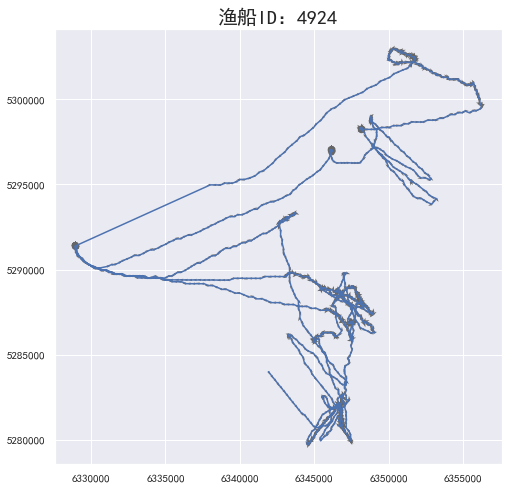

In [23]:
# 绘制全局
show_one_path(df_4924_time, figsize=(8, 8), fontsize=20)

## 全局间隔

In [24]:
# train清洗

for file in tqdm(train_files):
    df = pd.read_csv(f'{train_path}/{file}')
    df = df_angle_handle(df)
    df = extract_dt(df)
    df = extract_distance(df)
    df = df_time_cos_sin_handle(df)
    df = extract_statistic(df)
    df.to_csv(f"../../input/train_time/{file}")

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [318]:
del df
gc.collect()

NameError: name 'df' is not defined

In [26]:
# test清洗

for file in tqdm(test_files):
    df = pd.read_csv(f'{test_path}/{file}')
    df = df_angle_handle(df)
    df = extract_dt(df)
    df = extract_distance(df)
    df = df_time_cos_sin_handle(df)
    df = extract_statistic(df)
    df.to_csv(f"../../input/test_time/{file}")

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [319]:
del df
gc.collect()

NameError: name 'df' is not defined

### 文件链接

In [4]:
new_train_path = '../../input/train_time'
new_test_path = '../../input/test_time'

new_train_files = os.listdir(new_train_path)
new_test_files = os.listdir(new_test_path)

In [5]:
ret = []
for file in tqdm(new_train_files):
    df_train = pd.read_csv(f'{new_train_path}/{file}')
    df_train = df_train.head(3)
    ret.append(df_train)
df_train = pd.concat(ret)
df_train.to_hdf('../../input/train_id_head3.h5', 'df', mode='w')

In [6]:
print(df_train.shape[0])
del ret
gc.collect()

21000


42

In [7]:
ret = []
for file in tqdm(new_test_files):
    df_test = pd.read_csv(f'{new_test_path}/{file}')
    # df_test = df_test.drop_duplicates(['x', 'y'], keep='last')
    df_test = df_test.head(3)
    ret.append(df_test)
df_test = pd.concat(ret)
df_test.to_hdf('../../input/test_id_head3.h5', 'df', mode='w')

In [8]:
del ret
gc.collect()

64

In [9]:
df_test.head(3)

,Unnamed: 0,渔船ID,x,y,速度,time,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec,x_past,y_past,x_step,y_step,xy_distance_step,xy_velocity_step,sin_hour,cos_hour,sin_minute,cos_minute,sin_second,cos_second,x_max,x_min,x_mean,x_median,x_std,x_skew,x_mode,y_max,y_min,y_mean,y_median,y_std,y_skew,y_mode,day_max,day_min,day_mean,day_median,day_std,day_skew,day_mode,速度_max,速度_min,速度_mean,速度_median,速度_std,速度_skew,速度_mode,xy_velocity_step_max,xy_velocity_step_min,xy_velocity_step_mean,xy_velocity_step_median,xy_velocity_step_std,xy_velocity_step_skew,xy_velocity_step_mode,xy_distance_step_max,xy_distance_step_min,xy_distance_step_mean,xy_distance_step_median,xy_distance_step_std,xy_distance_step_skew,xy_distance_step_mode,time_step_sec_max,time_step_sec_min,time_step_sec_mean,time_step_sec_median,time_step_sec_std,time_step_sec_skew,time_step_sec_mode,x_step_max,x_step_min,x_step_mean,x_step_median,x_step_std,x_step_skew,x_step_mode,y_step_max,y_step_min,y_step_mean,y_step_median,y_step_std,y_step_skew,y_step_mode,sin_angle_max,sin_angle_min,sin_angle_mean,sin_angle_median,sin_angle_std,sin_angle_skew,sin_angle_mode,cos_angle_max,cos_angle_min,cos_angle_mean,cos_angle_median,cos_angle_std,cos_angle_skew,cos_angle_mode,day_past,x_past_max,y_past_max,square_area,long_stop_1000_count,long_stop_600_count,long_stop_1000_rate,long_stop_600_rate,short_report_count,short_report_rete,no_move_distance_count,no_move_distance_rate,daytime_count,daytime_rate
0,0,7000,7.118845e+06,5.918277e+06,0.11,1900-11-03 11:54:32,0.000000,1.000000,11,3,11,54,32,85053,600,49404.851390,-48259.911960,-94.755916,-7.487033,95.051245,0.158155,0.258819,-0.965926,-0.587785,0.809017,-0.207912,-0.978148,7.119130e+06,7.069441e+06,7.092492e+06,7.087014e+06,12325.511892,0.977247,7.083957e+06,5.966537e+06,5.893360e+06,5.918416e+06,5.918174e+06,7709.052316,3.036503,5.919921e+06,31,1,6.49866,2.0,10.764244,1.836671,1.0,10.09,0.0,1.656139,0.22,2.891711,1.75208,0.11,5.080716,0.0,0.834028,0.052548,1.539641,1.7679,0.0,6082.455686,0.0,591.944065,95.051245,1181.546296,2.454077,0.0,3002,0,691.294906,601.0,300.357214,2.824573,601.0,5783.000043,-4976.855593,132.452685,0.0,816.820992,0.49739,0.0,5264.607262,-5825.00317,-129.383142,0.0,1022.652899,-1.619231,0.0,0.999848,-1.0,0.09884,0.0,0.581457,-0.158039,0.0,1.0,-1.0,0.172563,0.325568,0.790533,-0.326795,1.0,30,49689.118453,73177.359157,3.636118e+09,52,217,0.13941,0.581769,2,0.005362,186,0.49866,201,0.538874
1,1,7000,7.118940e+06,5.918285e+06,0.32,1900-11-03 11:44:32,-0.241922,0.970296,11,3,11,44,32,84453,589,49499.607306,-48252.424927,-7.738505,110.571647,110.842111,0.187868,0.258819,-0.965926,-0.994522,-0.104528,-0.207912,-0.978148,7.119130e+06,7.069441e+06,7.092492e+06,7.087014e+06,12325.511892,0.977247,NaN,5.966537e+06,5.893360e+06,5.918416e+06,5.918174e+06,7709.052316,3.036503,NaN,31,1,6.49866,2.0,10.764244,1.836671,NaN,10.09,0.0,1.656139,0.22,2.891711,1.75208,NaN,5.080716,0.0,0.834028,0.052548,1.539641,1.7679,NaN,6082.455686,0.0,591.944065,95.051245,1181.546296,2.454077,NaN,3002,0,691.294906,601.0,300.357214,2.824573,NaN,5783.000043,-4976.855593,132.452685,0.0,816.820992,0.49739,NaN,5264.607262,-5825.00317,-129.383142,0.0,1022.652899,-1.619231,NaN,0.999848,-1.0,0.09884,0.0,0.581457,-0.158039,NaN,1.0,-1.0,0.172563,0.325568,0.790533,-0.326795,NaN,30,49689.118453,73177.359157,3.636118e+09,52,217,0.13941,0.581769,2,0.005362,186,0.49866,201,0.538874
2,2,7000,7.118948e+06,5.918174e+06,0.11,1900-11-03 11:34:43,0.000000,1.000000,11,3,11,34,43,83864,1213,49507.345810,-48362.996574,0.000000,0.000000,0.000000,0.000000,0.258819,-0.965926,-0.406737,-0.913545,-0.978148,-0.207912,7.119130e+06,7.069441e+06,7.092492e+06,7.087014e+06,12325.511892,0.977247,NaN,5.966537e+06,5.893360e+06,5.918416e+06,5.918174e+06,7709.052316,3.036503,NaN,31,1,6.49866,2.0,10.764244,1.836671,NaN,10.09,0.0,1.656139,0.22,2.891711,1.75208,NaN,5.080716,0.0,0.834028,0.052548,1.539641,1.7679,NaN,6082.455686,0.0,591.944065,95.051245,1181.546296,2.454077

###  读取文件-清洗从这里开始

In [10]:
# 读取文件
df_train = pd.read_hdf('../../input/train_id_head3.h5')
df_test = pd.read_hdf('../../input/test_id_head3.h5')

In [11]:
df_test = df_test.drop_duplicates('渔船ID')
df_test = df_test.reset_index(drop=True)

In [12]:
df_train = df_train.drop_duplicates('渔船ID')
df_train = df_train.reset_index(drop=True)

In [13]:
df_train = df_train.drop(['Unnamed: 0'], axis=1)

In [14]:
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [15]:
df_train.head(3)

,渔船ID,x,y,速度,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec,x_past,y_past,x_step,y_step,xy_distance_step,xy_velocity_step,sin_hour,cos_hour,sin_minute,cos_minute,sin_second,cos_second,x_max,x_min,x_mean,x_median,x_std,x_skew,x_mode,y_max,y_min,y_mean,y_median,y_std,y_skew,y_mode,day_max,day_min,day_mean,day_median,day_std,day_skew,day_mode,速度_max,速度_min,速度_mean,速度_median,速度_std,速度_skew,速度_mode,xy_velocity_step_max,xy_velocity_step_min,xy_velocity_step_mean,xy_velocity_step_median,xy_velocity_step_std,xy_velocity_step_skew,xy_velocity_step_mode,xy_distance_step_max,xy_distance_step_min,xy_distance_step_mean,xy_distance_step_median,xy_distance_step_std,xy_distance_step_skew,xy_distance_step_mode,time_step_sec_max,time_step_sec_min,time_step_sec_mean,time_step_sec_median,time_step_sec_std,time_step_sec_skew,time_step_sec_mode,x_step_max,x_step_min,x_step_mean,x_step_median,x_step_std,x_step_skew,x_step_mode,y_step_max,y_step_min,y_step_mean,y_step_median,y_step_std,y_step_skew,y_step_mode,sin_angle_max,sin_angle_min,sin_angle_mean,sin_angle_median,sin_angle_std,sin_angle_skew,sin_angle_mode,cos_angle_max,cos_angle_min,cos_angle_mean,cos_angle_median,cos_angle_std,cos_angle_skew,cos_angle_mode,day_past,x_past_max,y_past_max,square_area,long_stop_1000_count,long_stop_600_count,long_stop_1000_rate,long_stop_600_rate,short_report_count,short_report_rete,no_move_distance_count,no_move_distance_rate,daytime_count,daytime_rate
0,0,6.152038e+06,5.124873e+06,2.59,1900-11-10 11:58:19,拖网,0.978148,-0.207912,11,10,11,58,19,85731,600,33686.667453,-5798.943044,808.914660,-344.632139,879.269150,1.463010,0.258819,-0.965926,-0.207912,0.978148,0.913545,-0.406737,6.152038e+06,6.118352e+06,6.119351e+06,6.118352e+06,5037.320747,5.255558,6.118352e+06,5.130781e+06,5.124873e+06,5.130494e+06,5.130672e+06,850.264541,-4.762308,5.130672e+06,10,7,8.502415,8.5,0.950975,0.001538,8.0,9.39,0.0,0.265966,0.00,1.321248,5.520205,0.00,5.115562,0.0,0.136127,0.0,0.679070,5.515274,0.0,4745.887438,0.0,86.879282,0.0,449.486694,6.277462,0.0,2343,0,624.471014,600.0,171.039545,4.491647,600.0,3816.791567,-1.939802,81.368762,0.0,420.811680,5.887690,0.0,620.168819,-2820.558404,-14.007109,0.0,160.276396,-13.645926,0.0,1.000000,0.000000,0.043957,0.0,0.201004,4.378414,0.0,1.0,-0.629320,0.945962,1.000000,0.251140,-4.607238,1.0,3,33686.667453,5907.975523,1.990200e+08,18,80,0.043478,0.193237,2,0.004831,391,0.944444,228,0.550725
1,1,6.076254e+06,5.061743e+06,3.99,1900-11-10 11:40:21,拖网,-0.990268,0.139173,11,10,11,40,21,85187,438,-26195.691107,-51017.083421,-1125.824602,-76.379902,1128.412568,2.570416,0.258819,-0.965926,-0.866025,-0.500000,0.809017,-0.587785,6.102450e+06,6.049472e+06,6.091460e+06,6.102450e+06,16543.394419,-1.058454,6.102450e+06,5.112874e+06,5.042857e+06,5.094050e+06,5.112760e+06,26764.042729,-0.802446,5.112760e+06,10,7,8.522078,9.0,0.960228,-0.036456,9.0,10.47,0.0,1.607922,0.05,2.412688,1.590284,0.00,5.223936,0.0,0.736940,0.0,1.163551,1.709430,0.0,5828.114792,0.0,493.589310,0.0,846.431809,2.428791,0.0,2948,0,670.096104,600.0,298.696105,4.263346,600.0,1645.199578,-3521.669135,-68.040756,0.0,644.454376,-1.457187,0.0,981.739643,-5621.840326,-132.511905,0.0,723.286591,-3.455362,0.0,1.000000,-0.997564,0.017881,0.0,0.483033,0.049906,0.0,1.0,-0.999848,0.600858,1.000000,0.637959,-1.303134,1.0,3,52978.013345,70016.655842,3.709343e+09,35,94,0.090909,0.244156,1,0.002597,244,0.633766,209,0.542857
2,10,6.321032e+06,5.242805e+06,4.48,1900-11-10 11:49:36,拖网,-0.544639,-0.838671,11,10,11,49,36,84833,1210,74912.303386,1867.530665,-1721.384128,-1523.783676,2298.930188,1.898373,0.258819,-0.965926,-0.913545,0.406737,-0.587785,-0.809017,6.346913e+06,6.246119e+06,6.262484e+06,6.246120e+06,32280.567149,1.623040,6.246120e+06,5.265810e+06,5.229867e+06,5.242458e+06,5.240937e+06,5975.460236,2.198003,5.240937e+06,10,7,8.486146,9.0,0.981101,-0.049805,9.0,10.09,0.0,1.313854,0.22,2.442825,2.145410,0.11,4.686100,0.0,0.645806,0.0,1.235039,1.902998,0.0,5526.897410,

In [16]:
def drop_unnecessary_col(df):
    unneccessary = [# 'x', 'y', 'time', '速度', 'time',  # 结束时候的原始数据
                    'time',
                    'sin_angle', 'cos_angle',
                    'month', 'day', 'hour', 'minute', 'second', 'time_past_sec', 'time_step_sec',
                    'x_past', 'y_past', 'x_step', 'y_step', 
                    'xy_distance_step', 'xy_velocity_step', 
                    'sin_hour', 'cos_hour', 
                    'sin_minute', 'cos_minute',
                    'sin_second', 'cos_second',
                    # 'x_max', 'x_min', 'x_mean', 'x_median', 'x_std', 'x_skew', 'x_mode',
                    # 'y_max', 'y_min', 'y_mean', 'y_median', 'y_std', 'y_skew', 'y_mode', 
                    'day_max', 'day_min', 'day_mean', 'day_median', 'day_std', 'day_skew', 'day_mode',
                    #'速度_max', '速度_min', '速度_mean', '速度_median', '速度_std', '速度_skew', '速度_mode',
                    'xy_velocity_step_max', 'xy_velocity_step_min', 
                    'xy_velocity_step_mean', 
                    'xy_velocity_step_median', 'xy_velocity_step_std', 'xy_velocity_step_skew', 'xy_velocity_step_mode',
                    'xy_distance_step_max', 'xy_distance_step_min', 
                    'xy_distance_step_mean', 
                    'xy_distance_step_median', 'xy_distance_step_std', 'xy_distance_step_skew', 'xy_distance_step_mode',
                    'time_step_sec_max', 
                    'time_step_sec_min', 
                    'time_step_sec_mean', 
                    'time_step_sec_median', 'time_step_sec_std', 'time_step_sec_skew', 'time_step_sec_mode',
                    'x_step_max', 
                    'x_step_min', 
                    'x_step_mean', 'x_step_median', 'x_step_std', 'x_step_skew', 'x_step_mode', 
                    'y_step_max', 
                    'y_step_min', 
                    'y_step_mean', 'y_step_median', 'y_step_std', 'y_step_skew', 'y_step_mode', 
                    'sin_angle_max','sin_angle_min', 'sin_angle_mean', 'sin_angle_median', 'sin_angle_std', 'sin_angle_skew', 'sin_angle_mode',
                    'cos_angle_max','cos_angle_min', 'cos_angle_mean', 'cos_angle_median', 'cos_angle_std', 'cos_angle_skew', 'cos_angle_mode',
                    'day_past',
                    'x_past_max', 'y_past_max', 
                    'square_area', 
                    'long_stop_1000_count', 
                    'long_stop_1000_rate', 
                    'long_stop_600_count', 
                    # 'long_stop_600_rate',
                    'short_report_count', 'short_report_rete',
                    'no_move_distance_count', 
                    'no_move_distance_rate',
                    'daytime_count', 
                    'daytime_rate',
                    ]
    df = df.drop(unneccessary, axis=1)
    
    return df

In [17]:
df_train_clean = drop_unnecessary_col(df_train.copy())
df_test_clean = drop_unnecessary_col(df_test.copy())

In [18]:
df_train_clean.head(3)

,渔船ID,x,y,速度,type,x_max,x_min,x_mean,x_median,x_std,x_skew,x_mode,y_max,y_min,y_mean,y_median,y_std,y_skew,y_mode,速度_max,速度_min,速度_mean,速度_median,速度_std,速度_skew,速度_mode,long_stop_600_rate
0,0,6.152038e+06,5.124873e+06,2.59,拖网,6.152038e+06,6.118352e+06,6.119351e+06,6.118352e+06,5037.320747,5.255558,6.118352e+06,5.130781e+06,5.124873e+06,5.130494e+06,5.130672e+06,850.264541,-4.762308,5.130672e+06,9.39,0.0,0.265966,0.00,1.321248,5.520205,0.00,0.193237
1,1,6.076254e+06,5.061743e+06,3.99,拖网,6.102450e+06,6.049472e+06,6.091460e+06,6.102450e+06,16543.394419,-1.058454,6.102450e+06,5.112874e+06,5.042857e+06,5.094050e+06,5.112760e+06,26764.042729,-0.802446,5.112760e+06,10.47,0.0,1.607922,0.05,2.412688,1.590284,0.00,0.244156
2,10,6.321032e+06,5.242805e+06,4.48,拖网,6.346913e+06,6.246119e+06,6.262484e+06,6.246120e+06,32280.567149,1.623040,6.246120e+06,5.265810e+06,5.229867e+06,5.242458e+06,5.240937e+06,5975.460236,2.198003,5.240937e+06,10.09,0.0,1.313854,0.22,2.442825,2.145410,0.11,0.534005


In [19]:
df_train_clean.shape

(7000, 27)

## 训练测试

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import preprocessing

In [21]:
label_dict = {"拖网": 0,
             "围网": 1,
             "刺网": 2}

df_train_clean['type'] = df_train_clean['type'].apply(lambda x: label_dict[x])

In [22]:
df_train_clean.head(3)

,渔船ID,x,y,速度,type,x_max,x_min,x_mean,x_median,x_std,x_skew,x_mode,y_max,y_min,y_mean,y_median,y_std,y_skew,y_mode,速度_max,速度_min,速度_mean,速度_median,速度_std,速度_skew,速度_mode,long_stop_600_rate
0,0,6.152038e+06,5.124873e+06,2.59,0,6.152038e+06,6.118352e+06,6.119351e+06,6.118352e+06,5037.320747,5.255558,6.118352e+06,5.130781e+06,5.124873e+06,5.130494e+06,5.130672e+06,850.264541,-4.762308,5.130672e+06,9.39,0.0,0.265966,0.00,1.321248,5.520205,0.00,0.193237
1,1,6.076254e+06,5.061743e+06,3.99,0,6.102450e+06,6.049472e+06,6.091460e+06,6.102450e+06,16543.394419,-1.058454,6.102450e+06,5.112874e+06,5.042857e+06,5.094050e+06,5.112760e+06,26764.042729,-0.802446,5.112760e+06,10.47,0.0,1.607922,0.05,2.412688,1.590284,0.00,0.244156
2,10,6.321032e+06,5.242805e+06,4.48,0,6.346913e+06,6.246119e+06,6.262484e+06,6.246120e+06,32280.567149,1.623040,6.246120e+06,5.265810e+06,5.229867e+06,5.242458e+06,5.240937e+06,5975.460236,2.198003,5.240937e+06,10.09,0.0,1.313854,0.22,2.442825,2.145410,0.11,0.534005


In [23]:
X = df_train_clean.drop(['type', '渔船ID'], axis=1)
y = df_train_clean['type']

In [24]:
clf = xgb.XGBClassifier(max_depth=6, 
                          learning_rate=0.01, 
                          n_estimators=1500, 
                          objective='multi:softmax',
                          n_jobs=6, 
                          )


fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
models = []

for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    # val_pred = model.predict_proba(X.iloc[val_idx])
    val_pred = clf.predict(X.iloc[val_idx])
    val_y = y.iloc[val_idx]
    print(index, 'val f1', metrics.f1_score(val_y, val_pred, average='macro'))

0 val f1 0.9124124444728539
1 val f1 0.869981541138365
2 val f1 0.9057987711213519
3 val f1 0.887392909277012
4 val f1 0.8848310349770419
5 val f1 0.8606495638987676


In [298]:
val_pred

array([1, 2, 0, ..., 2, 0, 0], dtype=int64)

## 效果记录：

### 原始特征：

x, y ,方向， 速度，x_max	x_min	x_mean	x_median	x_std	x_skew	x_mode

结果：
```
0 val f1 0.8643986730943253
1 val f1 0.8546321511246111
2 val f1 0.8676085475875966
3 val f1 0.882271556995474
4 val f1 0.8725902231699912
5 val f1 0.834198846655633
```

### 当前测试特征：

day系列
```
0 val f1 0.8656952395579918
1 val f1 0.8510970343676649
2 val f1 0.8642845863215061
3 val f1 0.8781559970020827
4 val f1 0.8669883339610588
5 val f1 0.8325234007866822
```

## 结果

### 坏特征：

'day_past',
```
0 val f1 0.8557100097638014
1 val f1 0.8552193773888558
2 val f1 0.867533260247034
3 val f1 0.8829818441059084
4 val f1 0.8730826380874565
5 val f1 0.8362966877386929
```

白天比例 daytime_rate：
```
0 val f1 0.862378617674723
1 val f1 0.8564889498531733
2 val f1 0.8650754551464197
3 val f1 0.8735777014127529
4 val f1 0.8728125947397478
5 val f1 0.8373666788946047
```

原地不动的比例 no_move_distance_rate：
```
0 val f1 0.8599204515764997
1 val f1 0.8581135545618676
2 val f1 0.8704458901204286
3 val f1 0.8780788594181722
4 val f1 0.8736056540668485
5 val f1 0.830643339998348
```
square_area
```
0 val f1 0.871319231890964
1 val f1 0.8555430609062734
2 val f1 0.8697547809812569
3 val f1 0.883943116429691
4 val f1 0.8716691424155262
5 val f1 0.8275925295288573
```
x_step， y_step 系列：测试多种组合，都很垃圾
```
0 val f1 0.8709683209572455
1 val f1 0.8464896051200793
2 val f1 0.8613726890591366
3 val f1 0.8793113031279889
4 val f1 0.8714815893749629
5 val f1 0.8223228459421796
```

### 一般般的特征

1000秒以上停止的比例 long_stop_1000_rate：
```
0 val f1 0.8774662570276967
1 val f1 0.8614957411781635
2 val f1 0.8717553284160745
3 val f1 0.8876339916720397
4 val f1 0.8701175008330592
5 val f1 0.8298727457722433
```

long_stop_600_count
```
0 val f1 0.8724082300586425
1 val f1 0.8657678680549156
2 val f1 0.8721858812439865
3 val f1 0.882795504743898
4 val f1 0.8791800258819378
5 val f1 0.8340901132823135
```
'x_past_max', 'y_past_max':
```
0 val f1 0.8633555179653754
1 val f1 0.8607063822784723
2 val f1 0.8798475902007423
3 val f1 0.8806486354318716
4 val f1 0.8752228163992871
5 val f1 0.8383393579804553
```
time_step 系列，不要min，max
```
0 val f1 0.8746833886735806
1 val f1 0.8605446643616608
2 val f1 0.8655965952589746
3 val f1 0.8885489992739247
4 val f1 0.8673530299908113
5 val f1 0.8368031046291916
```
xy_velocity系列，不要minmax
```
0 val f1 0.8698941048259412
1 val f1 0.8535833579355069
2 val f1 0.8617135964645545
3 val f1 0.8854573673206815
4 val f1 0.8714416278699076
5 val f1 0.8368959201717822
```
xy_velocity系列
```
0 val f1 0.8658243759124691
1 val f1 0.8489441441198623
2 val f1 0.8599661402415609
3 val f1 0.8865980633657401
4 val f1 0.8774482432170734
5 val f1 0.8400826506266362
```

### 好的特征： 

两个0.88以上

600秒以上停止的比例 long_stop_600_rate：

```
0 val f1 0.8761090037905465
1 val f1 0.8676076095230464
2 val f1 0.8736381757569509
3 val f1 0.8993197168265379
4 val f1 0.8860902754390798
5 val f1 0.8389905800700307
```

xy_distance 系列，去掉minmax
```
0 val f1 0.8659136274353666
1 val f1 0.8621502386276861
2 val f1 0.862977631468401
3 val f1 0.8810669295768524
4 val f1 0.880518515447836
5 val f1 0.8348698383655853
```


In [ ]:
# this is prediction
# results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# bst.save_model('0001.model')
# dump model
# bst.dump_model('dump.raw.txt')
# dump model with feature map
# bst.dump_model('dump.nice.txt', '../data/featmap.txt')

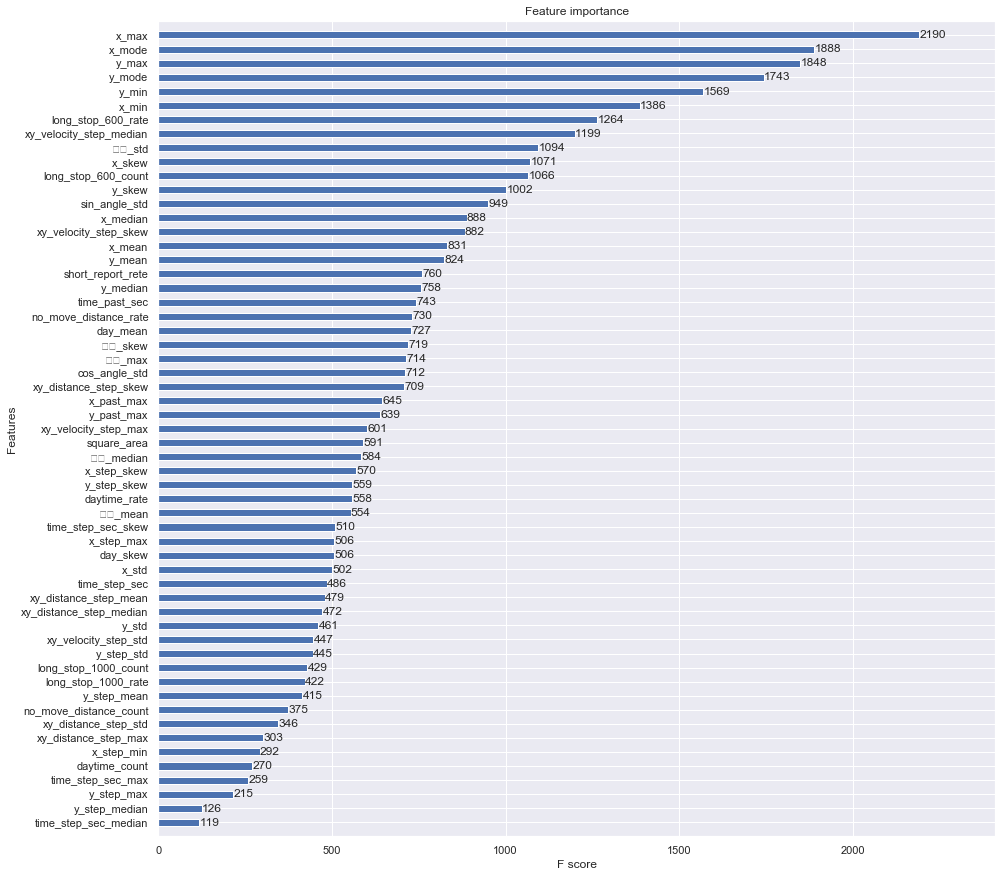

In [426]:
fig,ax = plt.subplots(figsize=(15,15))
xgb.plot_importance(bst,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()

### ID80尝试拆分

ID 80 的图片，特征很像围网，绕圈圈。但是是拖网

In [556]:
file = str(80)
df_check = pd.read_csv(f'{new_train_path}/{file}.csv')
print(f"作业类型：{df_check['type'].unique()}")
print(f"数据维度：{df_check.shape}")

作业类型：['拖网']
数据维度：(409, 16)


0

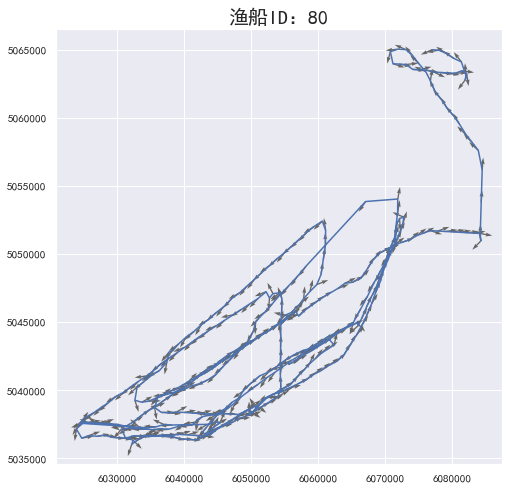

In [557]:
# 绘制全局
show_one_path(df_check.iloc[:], figsize=(8, 8), fontsize=20)

In [558]:
df_check

,Unnamed: 0,渔船ID,x,y,速度,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec
0,0,80,6.077035e+06,5.064985e+06,3.29,1900-11-03 11:54:03,拖网,-0.978148,-0.207912,11,3,11,54,3,85786,601
1,1,80,6.078056e+06,5.064956e+06,3.45,1900-11-03 11:44:02,拖网,-0.996195,-0.087156,11,3,11,44,2,85185,600
2,2,80,6.079175e+06,5.064706e+06,3.29,1900-11-03 11:34:02,拖网,-0.951057,0.309017,11,3,11,34,2,84585,600
3,3,80,6.080292e+06,5.064348e+06,3.89,1900-11-03 11:24:02,拖网,-0.945519,0.325568,11,3,11,24,2,83985,600
4,4,80,6.081411e+06,5.064098e+06,4.05,1900-11-03 11:14:02,拖网,-0.848048,0.529919,11,3,11,14,2,83385,599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,404,80,6.060226e+06,5.043286e+06,4.37,1900-10-31 12:44:17,拖网,0.951057,0.309017,10,31,12,44,17,2400,600
405,405,80,6.058990e+06,5.042889e+06,4.26,1900-10-31 12:34:17,拖网,0.933580,0.358368,10,31,12,34,17,1800,601
406,406,80,6.057858e+06,5.042597e+06,4.37,1900-10-31 12:24:16,拖网,0.927184,0.374607,10,31,12,24,16,1199,600
407,407,80,6.056723e+06,5.042197e+06,3.99,1900-10-31 12:14:16,拖网,0.970296,0.241922,10,31,12,14,16,599,599


0

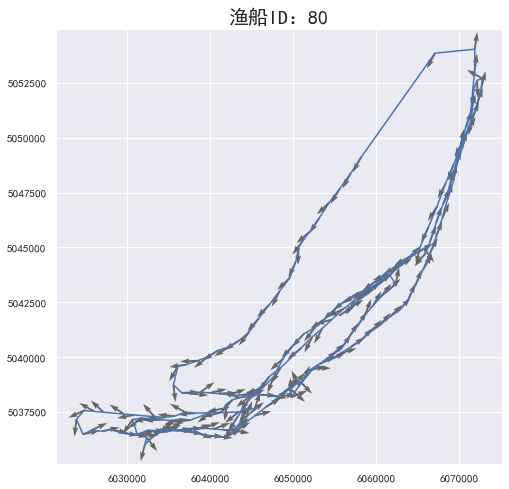

In [563]:
# 绘制一半
show_one_path(df_check.iloc[(len(df_check)//2):], figsize=(8, 8), fontsize=20)

0

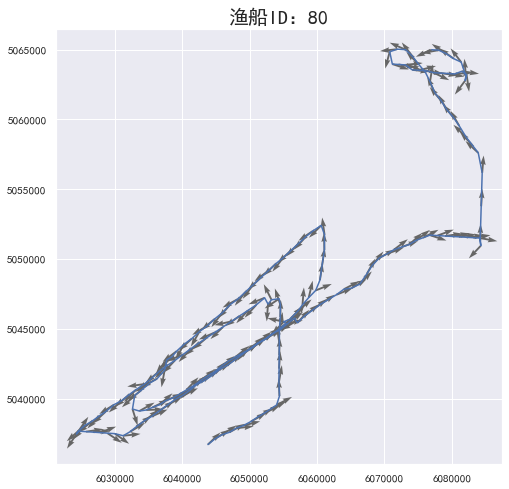

In [562]:
# 绘制一半
show_one_path(df_check.iloc[:(len(df_check)//2)], figsize=(8, 8), fontsize=20)

似乎没有明显改善？

### 继续检查

有一半躺尸，一半不躺尸的情况。

作业类型：['拖网']
数据维度：(291, 16)


0

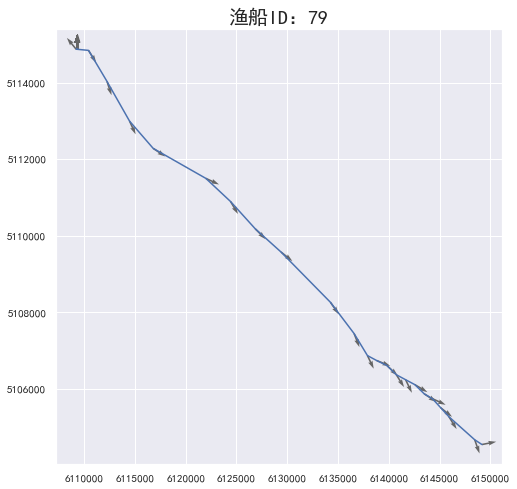

In [564]:
file = str(79)
df_check = pd.read_csv(f'{new_train_path}/{file}.csv')
print(f"作业类型：{df_check['type'].unique()}")
print(f"数据维度：{df_check.shape}")
      
# 绘制全局
show_one_path(df_check.iloc[:], figsize=(8, 8), fontsize=20)

0

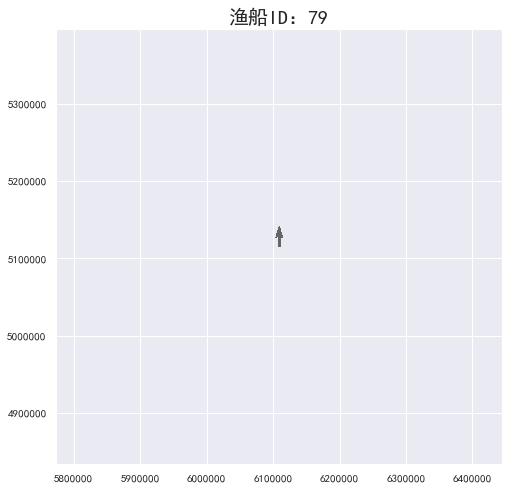

In [565]:
# 绘制一半
show_one_path(df_check.iloc[(len(df_check)//2):], figsize=(8, 8), fontsize=20)

0

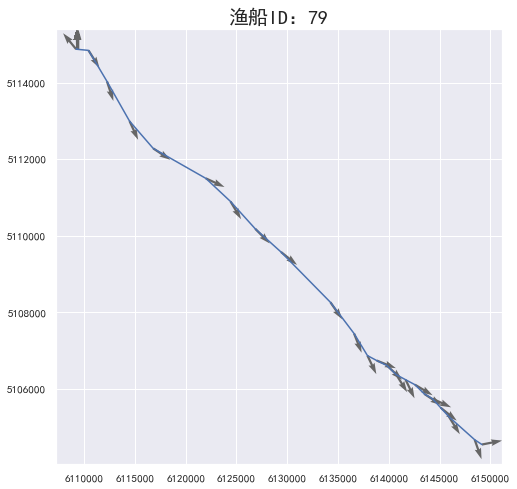

In [566]:
# 绘制一半
show_one_path(df_check.iloc[:(len(df_check)//2)], figsize=(8, 8), fontsize=20)

In [567]:
df_check

,Unnamed: 0,渔船ID,x,y,速度,time,type,sin_angle,cos_angle,month,day,hour,minute,second,time_past_sec,time_step_sec
0,0,79,6.149179e+06,5.104548e+06,2.00,1900-11-10 11:40:04,拖网,0.998630,0.052336,11,10,11,40,4,83897,450
1,1,79,6.148467e+06,5.104673e+06,3.08,1900-11-10 11:32:34,拖网,0.798636,-0.601815,11,10,11,32,34,83447,1949
2,2,79,6.145928e+06,5.105274e+06,3.35,1900-11-10 11:00:05,拖网,0.920505,-0.390731,11,10,11,0,5,81498,601
3,3,79,6.145117e+06,5.105510e+06,2.75,1900-11-10 10:50:04,拖网,0.978148,-0.207912,11,10,10,50,4,80897,599
4,4,79,6.144305e+06,5.105746e+06,3.45,1900-11-10 10:40:05,拖网,0.992546,-0.121869,11,10,10,40,5,80298,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,286,79,6.109313e+06,5.114870e+06,0.00,1900-11-07 13:00:16,拖网,0.000000,1.000000,11,7,13,0,16,2309,600
287,287,79,6.109313e+06,5.114870e+06,0.00,1900-11-07 12:50:16,拖网,0.000000,1.000000,11,7,12,50,16,1709,600
288,288,79,6.109313e+06,5.114870e+06,0.00,1900-11-07 12:40:16,拖网,0.000000,1.000000,11,7,12,40,16,1109,600
289,289,79,6.109313e+06,5.114870e+06,0.00,1900-11-07 12:30:16,拖网,0.000000,1.000000,11,7,12,30,16,509,509


## ID 86 拆分

这份可能比较有代表性

作业类型：['拖网']
数据维度：(320, 16)


0

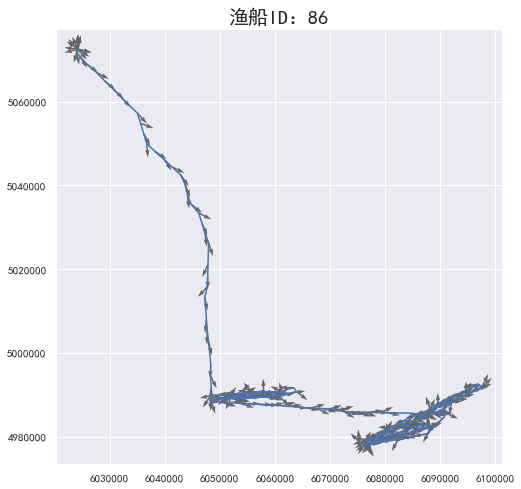

In [571]:
file = str(86)
df_check = pd.read_csv(f'{new_train_path}/{file}.csv')
print(f"作业类型：{df_check['type'].unique()}")
print(f"数据维度：{df_check.shape}")
      
# 绘制全局
show_one_path(df_check.iloc[:], figsize=(8, 8), fontsize=20)

0

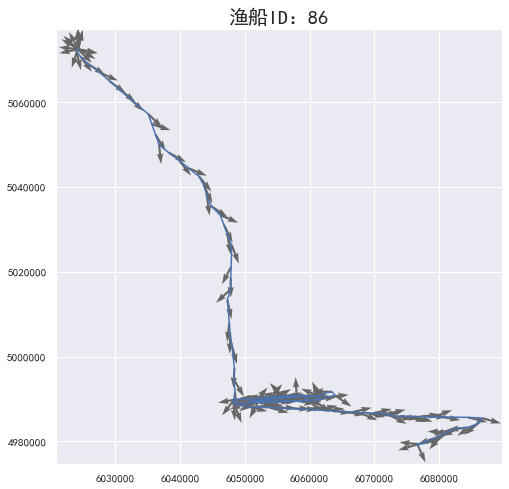

In [572]:
# 绘制一半
show_one_path(df_check.iloc[(len(df_check)//2):], figsize=(8, 8), fontsize=20)

0

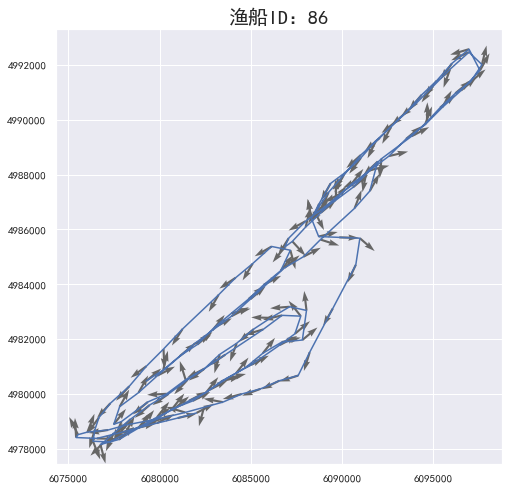

In [573]:
# 绘制一半
show_one_path(df_check.iloc[:(len(df_check)//2)], figsize=(8, 8), fontsize=20)

## 继续

只看围网和刺网？

作业类型：['拖网']
数据维度：(393, 16)


0

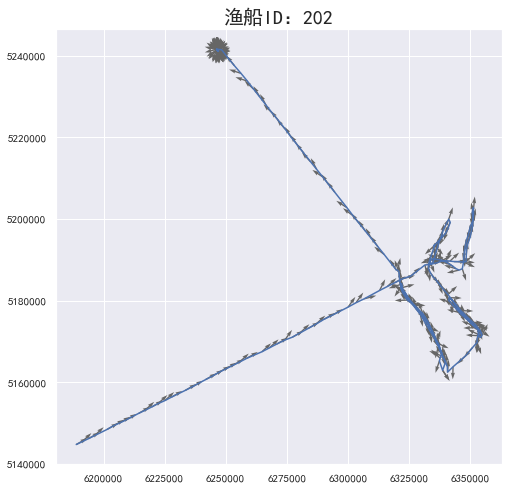

In [619]:
file = str(202)
df_check = pd.read_csv(f'{new_train_path}/{file}.csv')
print(f"作业类型：{df_check['type'].unique()}")
print(f"数据维度：{df_check.shape}")
      
# 绘制全局
show_one_path(df_check.iloc[:], figsize=(8, 8), fontsize=20)

0

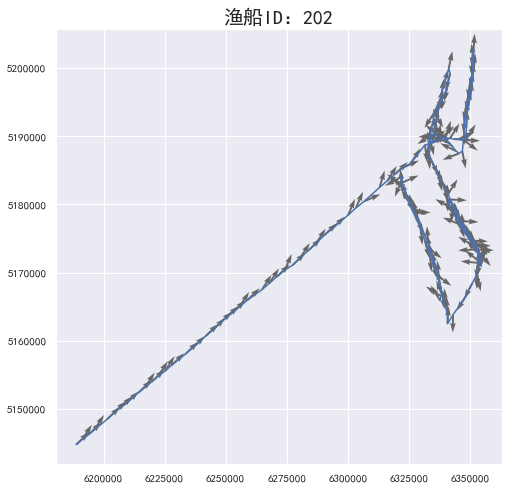

In [620]:
# 绘制一半

show_one_path(df_check.iloc[(len(df_check)//2):], figsize=(8, 8), fontsize=20)

0

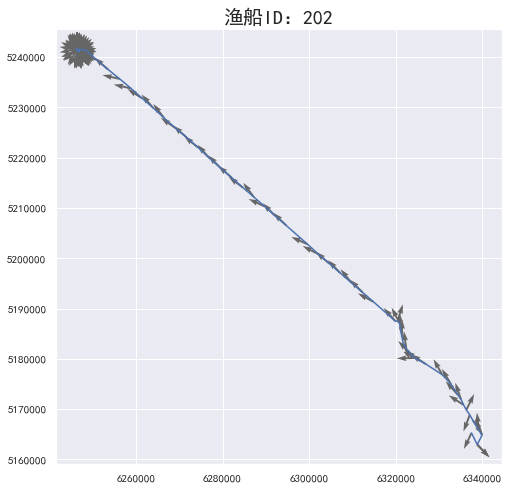

In [621]:
# 绘制一半

show_one_path(df_check.iloc[:(len(df_check)//2)], figsize=(8, 8), fontsize=20)

In [632]:
df_type = df_train.drop_duplicates(subset=['渔船ID'], keep='first')  # 去重
df_type = df_type[df_type['type'] != '拖网']

作业类型：['围网']
数据维度：(410, 16)


0

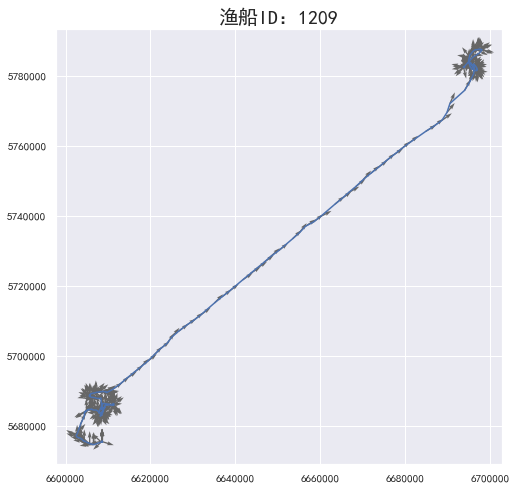

In [700]:
# 绘制全局
index = df_type['渔船ID'].values[65]
df_check = pd.read_csv(f'{new_train_path}/{index}.csv')
print(f"作业类型：{df_check['type'].unique()}")
print(f"数据维度：{df_check.shape}")
      
show_one_path(df_check.iloc[:], figsize=(8, 8), fontsize=20)